Wave Function Collapse Algorithm  
1. Have a set of tiles that will make up the world, together with rules which tiles fit next to each other.
2. Pick a random empty tile in the world and randomly choose one of the tiles to fill it with
3. Now propagate the neighboorhood rules to all cells, eliminating possibilities for which tiles can be placed where
4. Chose the empty tile with the lowest number of possibilities, and randomly pick one of the possible tiles to place there
5. Repeate the above steps until there are no more empty tiles.
6. Ein Backtracking ist evtl. notwendig wenn der algorithmus an einen punkt gelangt wo eine zelle keine möglichen tiles hat die dort plaziert werden könnten.
7. Wenn die regeln nicht gut gewählt sind, kann es (glaube ich) dazu kommen, dass bestimmte features nie generiert werden, oder dass man an einem Punkt ankommt wo eine zelle keine möglichen ausprägungen mehr hat.

The Tiles and the neighboorhood rules can be generated from an existing example.  
1. For that purpose the image (2D) or mesh (3D) is analyzed for equally sized cells which appear multiple times (in essence what a compression algorithm would do).
2. The szene is then split into these discrete chunks, and the neighboors of each chunk are analysed for infer neighboorhood rules.  
3. The downside here is that variations that did not appear in the input, but would be consistent with its rules will not appear in the output. The output will however look quite similar structurally to the input.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
choice = np.random.choice

## 1D

In [ ]:
def show_line(Line):
    plt.axis('off')
    plt.imshow([Line])

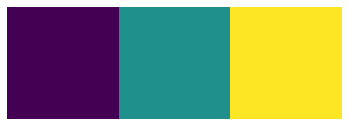

In [ ]:
show_line([1, 2, 3])

### Gradient

In [ ]:
def generate_gradient():
    Line = np.zeros(shape=10)
    N, = Line.shape
    X = np.random.choice(N)
    Line[X] = 1
    for x in range(X+1, N):
        Line[x] = Line[x-1] + 1
    for x in reversed(range(0, X)):
        Line[x] = Line[x+1] + 1
    return Line

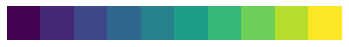

In [ ]:
show_line(generate_gradient())

### Simple Wave Function Collapse

#### Setup

In [ ]:
N = 10

In [ ]:
Line = np.zeros(N, dtype=int); Line

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

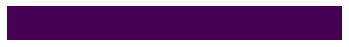

In [ ]:
show_line(Line)

In [ ]:
PossibleValuesRules = {
    0: (1, 3,),
    1: (0,),
    2: (1,),
    3: (2,)
}
NumberOfPossibleValues = len(PossibleValuesRules)
PossibleValues = list(PossibleValuesRules.keys())
PossibleValuesIdxs = np.arange(len(PossibleValues))
NumberOfPossibleValues, PossibleValuesRules, PossibleValues, PossibleValuesIdxs

(4, {0: (1, 3), 1: (0,), 2: (1,), 3: (2,)}, [0, 1, 2, 3], array([0, 1, 2, 3]))

In [ ]:
WaveFunction = np.ones(shape=(N, NumberOfPossibleValues), dtype=bool); WaveFunction

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [ ]:
LineHasCollapsed = np.zeros(shape=N, dtype=bool); LineHasCollapsed

array([False, False, False, False, False, False, False, False, False,
       False])

#### First Iteration

In [ ]:
X = choice(N); X

8

In [ ]:
# Jump back up to here when doing manual looping!

In [ ]:
WaveFunction[X]

array([False,  True, False,  True])

In [ ]:
PossibleIdxForX = PossibleValuesIdxs[WaveFunction[X]]

In [ ]:
assert len(PossibleIdxForX) > 0

In [ ]:
ChoiceIdxForX = choice(PossibleIdxForX); ChoiceIdxForX

1

In [ ]:
ChoiceForX = PossibleValues[PossibleValuesIdxs[ChoiceIdxForX]]; ChoiceForX

1

In [ ]:
Line[X] = ChoiceForX

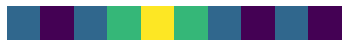

In [ ]:
show_line(Line)

#### Choice has been made, propagate changes

In [ ]:
LineHasCollapsed[X] = True; LineHasCollapsed

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [ ]:
WaveFunction[X] = False; # numpy broadcasting
WaveFunction

array([[False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False]])

In [ ]:
NumberOfPossibleValues, PossibleValuesRules, PossibleValues, PossibleValuesIdxs

(2, {0: (1, 3), 1: (0,), 2: (1,), 3: (2,)}, [0, 1, 2, 3], array([0, 1, 2, 3]))

In [ ]:
# for sublist in l: for item in sublist: yield item
def flatten(NestedList, Condition):
    return [Item for (SubList, C) in zip(NestedList, Condition) for Item in SubList if C]
flatten([[1, 2], [5, 6], [8, 6, 5]], [True, False, True])

[1, 2, 8, 6, 5]

In [ ]:
# [Value for (V, W) in zip(PossibleValues, OtherWaveFunction) for Value in PossibleValuesRules[V] if W]

array([[False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False]])

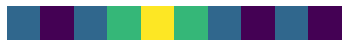

In [ ]:
WaveFunctionHasChanged = True
while WaveFunctionHasChanged: # execute at least once
    WaveFunctionHasChanged = False
    for i in range(0, N):
        if LineHasCollapsed[i]:
            # print(f'{i} Collapsed')
            continue # Dont update the wavefunction of a cell that has already collapsed
        CurrentElement      = Line[i]
        CurrentWaveFunction = WaveFunction[i]
        NewWaveFunction     = np.ones_like(CurrentWaveFunction)

        def check_element(idx):
            "Checks what values are permitted at the current element, based on what is present at this neighboor."
            OtherElement, OtherWaveFunction = Line[idx], WaveFunction[idx]
            if LineHasCollapsed[idx]:
                AllowedValues = PossibleValuesRules[OtherElement]
            else:
                AllowedValues = [Value for (V, W) in zip(PossibleValues, OtherWaveFunction) for Value in PossibleValuesRules[V] if W]
            for ValueIdx, Value in enumerate(PossibleValues):
                if Value in AllowedValues:
                    # if another cell has already made this value impossible, it can't be made possible again here.
                    NewWaveFunction[ValueIdx] &= True
                else:
                    NewWaveFunction[ValueIdx] = False

        if i > 0  : check_element(i-1)
        if i < N-1: check_element(i+1)
        NumberOfPossibleValues = sum(NewWaveFunction)
        assert NumberOfPossibleValues != 0, f'{i} {WaveFunction}'
        if NumberOfPossibleValues == 1: # Collapse this element
            Line[i]                = PossibleValues[PossibleValuesIdxs[NewWaveFunction][0]]
            LineHasCollapsed[i]    = True
            WaveFunction[i]        = False # numpy broadcasting
            WaveFunctionHasChanged = True
        else:
            WaveFunction[i] = NewWaveFunction
            WaveFunctionHasChanged |= any(CurrentWaveFunction != NewWaveFunction)
        # print(i, CurrentWaveFunction, NewWaveFunction)
show_line(Line)
WaveFunction

In [ ]:
Line

array([1, 0, 1, 2, 3, 2, 1, 0, 1, 0])

In [ ]:
LineHasCollapsed

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

#### first iteration done, now repeat until all fields are collapsed

In [ ]:
NumberOfPossibleStates = WaveFunction.sum(axis=1); NumberOfPossibleStates

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# Get the field with the lowest number of non-zero (non-collapsed) states.
# If there are multiple fields, pick one of those at random.
RemainingUncertainFields = np.flatnonzero(LineHasCollapsed == False); RemainingUncertainFields

array([], dtype=int64)

In [ ]:
if len(RemainingUncertainFields) == 0: print('STOP') # stop condition

STOP


In [ ]:
# There are two way of calculating what the number of least, non-zero, possibilities is:
# LeastNumberOfRemainingStates = np.min(NumberOfPossibleStates,
#                                       where=(LineHasCollapsed == False),
#                                       initial=NumberOfPossibleValues)

LeastNumberOfRemainingStates = np.min(NumberOfPossibleStates[RemainingUncertainFields]);

LeastNumberOfRemainingStates

2

In [ ]:
# Choose which cell to collapse next
X = choice(np.flatnonzero(NumberOfPossibleStates == LeastNumberOfRemainingStates)); X

0

In [ ]:
# Jump back to the top and run the algorithm again!

## 2D

In [ ]:
def show_image(Image):
    plt.axis('off')
    plt.imshow(Image)

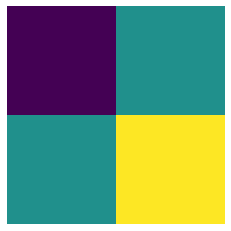

In [ ]:
show_image([[1, 2], [2, 3]])

In [ ]:
Grid = np.zeros(shape=(5, 5))

In [ ]:
Grid[0, 0] = 1

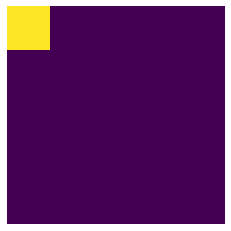

In [ ]:
show_image(Grid)

In [ ]:
Grid[0, 0] = 0

In [ ]:
N, M = Grid.shape
N, M

(5, 5)

In [ ]:
X, Y  = np.random.choice(N), np.random.choice(M)
X, Y

(4, 2)

In [ ]:
Grid[X, Y] = np.random.choice(3)

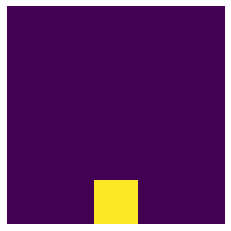

In [ ]:
show_image(Grid)

In [ ]:
NextTiles = [(3, 2), (4, 1), (4, 3)]
NextTile = NextTiles[np.random.choice(len(NextTiles))]
NextTile

(4, 1)

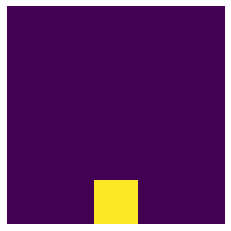

In [ ]:
show_image(Grid)